In [1]:
import pandas as pd
import pickle
import os
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import arviz
import pystan
import random
from sklearn.neighbors import KernelDensity
from sklearn.mixture import GaussianMixture

from scipy.spatial import cKDTree as KDTree
from scipy.stats import multivariate_normal, gaussian_kde, entropy, gamma
from fastkde import fastKDE
from entropy_estimators import continuous
import seaborn as sns
from tqdm.auto import tqdm
import seaborn as sns

# Helper functions    

In [2]:
def KLdivergence(x, y):
    # Check the dimensions are consistent
    x = np.atleast_2d(x)
    y = np.atleast_2d(y)

    n,d = x.shape
    m,dy = y.shape

    assert(d == dy)

    # Build a KD tree representation of the samples and find the nearest neighbour
    # of each point in x.
    xtree = KDTree(x)
    ytree = KDTree(y)

  # Get the first two nearest neighbours for x, since the closest one is the
  # sample itself.
    thresh = 1e-4
    #r = xtree.query(x, k=100, eps=.01, p=2)[0]
    #s = ytree.query(x, k=100, eps=.01, p=2)[0]

    r = xtree.query(x, k=100, eps=.01, p=2)[0]
    s = ytree.query(x, k=100, eps=.01, p=2)[0]

    r = r[np.arange(r.shape[0]), np.argmax(r > thresh, axis=1)] 
    s = s[np.arange(s.shape[0]), np.argmax(s > thresh, axis=1)]
    
    if math.isinf(-np.log(r/s).sum() * d / n + np.log(m / (n - 1.))):
        a = 0;

    # There is a mistake in the paper. In Eq. 14, the right side misses a negative sign
    # on the first term of the right hand side.
    return -np.log(r/s).sum() * d / n + np.log(m / (n - 1.))

def kl_mvn(m0, S0, m1, S1):
 
  # store inv diag covariance of S1 and diff between means
  N = m0.shape[0]
  iS1 = np.linalg.inv(S1)
  diff = m1 - m0

  # kl is made of three terms
  tr_term   = np.trace(iS1 @ S0)
  det_term  = np.log(np.linalg.det(S1)/np.linalg.det(S0)) #np.sum(np.log(S1)) - np.sum(np.log(S0))
  quad_term = diff.T @ np.linalg.inv(S1) @ diff #np.sum( (diff*diff) * iS1, axis=1)
  #print(tr_term,det_term,quad_term)
  return .5 * (tr_term + det_term + quad_term - N) 

def surprisal(dist, sample):
    kde = gaussian_kde(dist)
    prob = kde.evaluate(sample)
    return -np.log(prob)


def EIG(dist, grid, thinning_factor):
        print(np.arange(-1.9, 2, 0.25))
        
        for hypothetical_obs in grid:
            
            data["z"] = np.hstack(np.transpose(sample_data[0:total_samples,:]), hypothetical_obs)

            # get posterior samples
            fit = sm.sampling(data=data, iter=num_iter, chains=1, warmup = num_warmup,control=dict(adapt_delta=0.95));
        
            hyp_posterior = np.hstack((fit['mu'][0:len(fit['mu']):thinning_factor], \
                       fit['sigma'][0:len(fit['mu']):thinning_factor]))
            
            hyp_entropy_reduction = np.abs(continuous.get_h(posterior, k = 200) - continuous.get_h(hyp_posterior, k = 200))
            
            pp =  kde = gaussian_kde(dist)
            prob = kde.evaluate(hypothetical_obs)
            
            EIG += pp * hyp_entropy_reduction
        return EIG
  
  

Build model

In [3]:
# whether to recompile the stan program
DO_COMPILE = False

# simple noise or prior on noise
SIMPLE_NOISE = True

# stan program path
if SIMPLE_NOISE:
    stan_path = 'multi_feature_simple_noise.stan'
    pkl_file = 'model_simple_noise.pkl'
else:
    stan_path = 'multi_feature.stan'
    pkl_file = 'model.pkl'


def build_model(path, pkl_file=None, do_compile=True):
    if do_compile:
        sm = pystan.StanModel(file=path)
        if pkl_file is not None:
            with open(pkl_file, 'wb') as f:
                pickle.dump(sm, f)

    # if the program hasn't been complied, check that the file already exists
    else: 
        if os.path.isfile(pkl_file):
            sm = pickle.load(open(pkl_file, 'rb'))
        else:
            raise FileNotFoundError
    return sm


sm = build_model(path = stan_path, pkl_file=pkl_file, do_compile=DO_COMPILE)

Model parameters

In [85]:
# mu
mu_mean = 0
mu_sd = 0.5

# sd
sigma_alpha = 2
sigma_beta = 2


# lower bound of sigma prior
lower_sigma_bound = 0.1

# noise SD prior
epsilon_alpha = 1
epsilon_beta = 1

# for simple noise 
noise = 0.4

# environmental EIG
env_info = 0.01

Create data

In [86]:
# number of stimuli
sequence_length = 6

# number of features 
num_features = 1

# number of samples (max)
num_samples = 3000

# allocation of samples to exemplars
exemplar_idx = np.repeat(np.arange(1, sequence_length+1), num_samples/sequence_length)

# background / deviant mean values
background = np.repeat(1, num_features)
deviant = np.repeat(3, num_features)

# perceptual noise
sig = np.identity(num_features) * 0.001;

# deviant position
deviant_pos = 6

# stimulus means
exemplar_means = np.tile(background, (sequence_length, 1))
exemplar_means[deviant_pos-1] = deviant

Simulation parameters

In [99]:
# number of iterations and warmup per model run
num_iter = 20000
num_warmup = 4000

# number of total model runs
num_model_runs = 5

# how much to thin posteriors (value determines how we "retain every nth sample")
thinning_factor = 1

Initialize flags, variables, iterators 

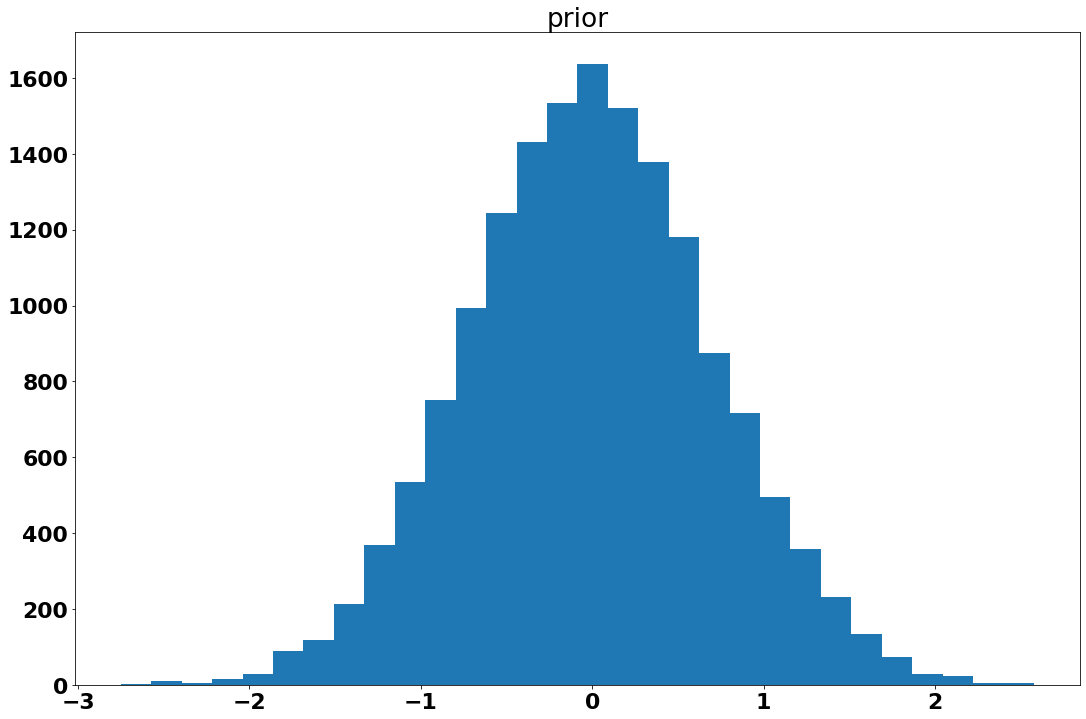

In [102]:
# Flags 
sample = True
policy = 'kl' # 'kl', 'surprisal', 'entropy' or 'eig'

# Variables
model_LT = np.zeros((num_model_runs, sequence_length))

# prior parameters
prior_mu = np.random.multivariate_normal(np.repeat(mu_mean, num_features), np.identity(num_features)*mu_sd, num_iter-num_warmup)

prior_sigma = np.empty((num_iter-num_warmup, num_features))
for i in np.arange(0, num_features):
    
    # compute truncated sigma prior
    nrm=gamma.cdf(100, a = sigma_alpha, scale = 1/sigma_beta)- gamma.cdf(lower_sigma_bound, a = sigma_alpha, scale = 1/sigma_beta)
    yr=np.random.rand(num_iter-num_warmup)*(nrm)+gamma.cdf(lower_sigma_bound,  a = sigma_alpha, scale = 1/sigma_beta)
    prior_sigma[:,i] = gamma.ppf(yr, a = sigma_alpha, scale = 1/sigma_beta)
    
    
prior_z_rep = np.empty((num_iter-num_warmup, num_features))
for i in np.arange(0, num_iter-num_warmup):
    prior_z_rep[i,:] = np.random.multivariate_normal(prior_mu[i,:], np.identity(num_features)*prior_sigma[i,:])

prior = np.hstack((prior_mu[0:len(prior_mu):thinning_factor], prior_sigma[0:len(prior_sigma):thinning_factor]))

data = {"mu_mean": mu_mean , "mu_sd": mu_sd, "sigma_alpha": sigma_alpha, "sigma_beta": sigma_beta, 
"epsilon_alpha": epsilon_alpha, "epsilon_beta": epsilon_beta, "noise": noise, "F": num_features}

stim_info = np.empty((num_model_runs, num_samples))
stim_info[:] = np.nan

plt.hist(prior[:,[0]], bins = 30);
plt.title('prior')
plt.show()

# Action loop

model run:  0


stimulus:  1
sample:  1

Gradient evaluation took 1.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.088297 seconds (Warm-up)
               0.271579 seconds (Sampling)
               0.359876 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 0.31328933873201015
stimulus:  1
sample:  2



Gradient evaluation took 1.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.328713 seconds (Warm-up)
               0.697291 seconds (Sampling)
               1.026 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 0.021329688423671778
stimulus:  1
sample:  3



Gradient evaluation took 1.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.38333 seconds (Warm-up)
               0.740789 seconds (Sampling)
               1.12412 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 0.003012690688237729
stimulus:  2
sample:  4



Gradient evaluation took 2.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.24 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.551792 seconds (Warm-up)
               0.658756 seconds (Sampling)
               1.21055 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 0.1799183498363427
stimulus:  2
sample:  5



Gradient evaluation took 3.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.526049 seconds (Warm-up)
               0.732926 seconds (Sampling)
               1.25897 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 0.005391577051269247
stimulus:  3
sample:  6



Gradient evaluation took 3.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.738362 seconds (Warm-up)
               0.588527 seconds (Sampling)
               1.32689 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 0.15086205379432183
stimulus:  3
sample:  7



Gradient evaluation took 3.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.38 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.696295 seconds (Warm-up)
               0.967368 seconds (Sampling)
               1.66366 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 0.025999886516035076
stimulus:  3
sample:  8



Gradient evaluation took 3.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.38 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.76371 seconds (Warm-up)
               0.541376 seconds (Sampling)
               1.30509 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 0.0016783577105671244
stimulus:  4
sample:  9

Gradient evaluation took 5.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.51 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.789307 seconds (Warm-up)
               0.631885 seconds (Sampling)
               1.42119 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 0.17882053498677916
stimulus:  4
sample:  10

Gradient evaluation took 2.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.24 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.805784 seconds (Warm-up)
               0.728513 seconds (Sampling)
               1.5343 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 0.0069090227714604935
stimulus:  5
sample:  11



Gradient evaluation took 1.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.12 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.840679 seconds (Warm-up)
               0.821458 seconds (Sampling)
               1.66214 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 0.07816112846265233
stimulus:  5
sample:  12



Gradient evaluation took 3.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.518079 seconds (Warm-up)
               0.621354 seconds (Sampling)
               1.13943 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 0.006040536972896748
stimulus:  6
sample:  13



Gradient evaluation took 4.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.49 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.634345 seconds (Warm-up)
               0.738531 seconds (Sampling)
               1.37288 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 2.8283325102543753
stimulus:  6
sample:  14

Gradient evaluation took 2.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.23 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.591401 seconds (Warm-up)
               0.68303 seconds (Sampling)
               1.27443 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 0.11398704404317239
stimulus:  6
sample:  15

Gradient evaluation took 1.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.13 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.410843 seconds (Warm-up)
               0.40085 seconds (Sampling)
               0.811693 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 0.0059900442494730255
model run:  1
stimulus:  1
sample:  1

Gradient evaluation took 1.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
Adjust your expectations accordingly!




Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.088403 seconds (Warm-up)
               0.336914 seconds (Sampling)
               0.425317 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 2.034522596011532
stimulus:  1
sample:  2



Gradient evaluation took 3.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.369122 seconds (Warm-up)
               0.620791 seconds (Sampling)
               0.989913 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 0.009071493191417757
stimulus:  2
sample:  3



Gradient evaluation took 2.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.22 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.528728 seconds (Warm-up)
               0.618328 seconds (Sampling)
               1.14706 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 0.15909817884194688
stimulus:  2
sample:  4



Gradient evaluation took 2.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.28 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.604036 seconds (Warm-up)
               0.760649 seconds (Sampling)
               1.36469 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 0.006579753938301791
stimulus:  3
sample:  5


/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack


Gradient evaluation took 2.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.24 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.682258 seconds (Warm-up)
               0.830737 seconds (Sampling)
               1.513 seconds (Total)

KL: 0.1784319984997742
stimulus:  3
sample:  6



Gradient evaluation took 3.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.7671 seconds (Warm-up)
               0.751365 seconds (Sampling)
               1.51846 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 0.008828715527200048
stimulus:  4
sample:  7



Gradient evaluation took 1.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.764505 seconds (Warm-up)
               0.676871 seconds (Sampling)
               1.44138 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 0.1347829760040961
stimulus:  4
sample:  8



Gradient evaluation took 5.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.51 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.76148 seconds (Warm-up)
               0.730065 seconds (Sampling)
               1.49154 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 0.00851847657688351
stimulus:  5
sample:  9



Gradient evaluation took 5.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.56 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.855215 seconds (Warm-up)
               1.21189 seconds (Sampling)
               2.06711 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 0.07690483708196527
stimulus:  5
sample:  10



Gradient evaluation took 4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.4 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.882397 seconds (Warm-up)
               0.98681 seconds (Sampling)
               1.86921 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 0.013496836687627911
stimulus:  5
sample:  11



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

Gradient evaluation took 5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.5 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.854838 seconds (Warm-up)
               0.644066 seconds (Sampling)
               1.4989 seconds (Total)

KL: 0.0042999201102330575
stimulus:  6
sample:  12



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

Gradient evaluation took 3.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.719268 seconds (Warm-up)
               0.679281 seconds (Sampling)
               1.39855 seconds (Total)

KL: 2.9139445028159896
stimulus:  6
sample:  13

Gradient evaluation took 2.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.23 seconds.
Adjust your expecta

/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 0.06656804906373925
stimulus:  6
sample:  14

Gradient evaluation took 1.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.12 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.389229 seconds (Warm-up)
               0.610098 seconds (Sampling)
               0.999327 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 0.0077557196786484095
model run:  2


stimulus:  1
sample:  1

Gradient evaluation took 1.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.096682 seconds (Warm-up)
               0.453216 seconds (Sampling)
               0.549898 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 1.9631767141794063
stimulus:  1
sample:  2



Gradient evaluation took 3.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.347355 seconds (Warm-up)
               0.939264 seconds (Sampling)
               1.28662 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 0.00982722251755197
stimulus:  2
sample:  3



Gradient evaluation took 4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.4 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.549623 seconds (Warm-up)
               0.601746 seconds (Sampling)
               1.15137 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 0.18392487552342796
stimulus:  2
sample:  4

Gradient evaluation took 1.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.12 seconds.


Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.574928 seconds (Warm-up)
               0.632479 seconds (Sampling)
               1.20741 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 0.0029526199524612107
stimulus:  3
sample:  5


/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack


Gradient evaluation took 3.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.718923 seconds (Warm-up)
               0.783714 seconds (Sampling)
               1.50264 seconds (Total)

KL: 0.18648158173760626
stimulus:  3
sample:  6



Gradient evaluation took 3.7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.37 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.763095 seconds (Warm-up)
               0.786922 seconds (Sampling)
               1.55002 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 0.008235360991879048
stimulus:  4
sample:  7



Gradient evaluation took 2.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.23 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.784803 seconds (Warm-up)
               0.565337 seconds (Sampling)
               1.35014 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 0.1293521693905058
stimulus:  4
sample:  8



Gradient evaluation took 3.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.786185 seconds (Warm-up)
               0.662295 seconds (Sampling)
               1.44848 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 0.010131136011333003
stimulus:  4
sample:  9

Gradient evaluation took 3.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.794674 seconds (Warm-up)
               0.644727 seconds (Sampling)
               1.4394 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 0.05925554617581419
stimulus:  4
sample:  10



Gradient evaluation took 2.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.24 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.817617 seconds (Warm-up)
               1.43366 seconds (Sampling)
               2.25127 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 0.02335808107562748
stimulus:  4
sample:  11



Gradient evaluation took 3.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.808656 seconds (Warm-up)
               1.22514 seconds (Sampling)
               2.03379 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 0.0013925247894126525
stimulus:  5
sample:  12



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

Gradient evaluation took 1.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.849268 seconds (Warm-up)
               0.906914 seconds (Sampling)
               1.75618 seconds (Total)

KL: 0.07907984994865436
stimulus:  5
sample:  13



Gradient evaluation took 5.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.56 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.837753 seconds (Warm-up)
               0.764762 seconds (Sampling)
               1.60251 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 0.01925982637621404
stimulus:  5
sample:  14

Gradient evaluation took 4.5e-05 seconds


1000 transitions using 10 leapfrog steps per transition would take 0.45 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.462913 seconds (Warm-up)
               1.45534 seconds (Sampling)
               1.91825 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 0.007134173819460465
stimulus:  6
sample:  15

Gradient evaluation took 1.7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.17 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.588164 seconds (Warm-up)
               0.838263 seconds (Sampling)
               1.42643 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 3.2258547241058912
stimulus:  6
sample:  16

Gradient evaluation took 2.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.25 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.603507 seconds (Warm-up)
               0.781052 seconds (Sampling)
               1.38456 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 0.08759717098893516
stimulus:  6
sample:  17

Gradient evaluation took 3.7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.37 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.626842 seconds (Warm-up)
               0.729055 seconds (Sampling)
               1.3559 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 0.008886311717924533
model run:  3
stimulus:  1
sample:  1



Gradient evaluation took 1.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.13 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.128049 seconds (Warm-up)
               0.417901 seconds (Sampling)
               0.54595 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 2.171901621819562
stimulus:  1
sample:  2



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

Gradient evaluation took 2.7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.27 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.41289 seconds (Warm-up)
               0.581833 seconds (Sampling)
               0.994723 seconds (Total)

KL: 0.00911289194173226
stimulus:  2
sample:  3



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

Gradient evaluation took 5.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.52 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.537212 seconds (Warm-up)
               0.438389 seconds (Sampling)
               0.975601 seconds (Total)

KL: 0.17198429946566052
stimulus:  2
sample:  4



Gradient evaluation took 3.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.709857 seconds (Warm-up)
               0.604434 seconds (Sampling)
               1.31429 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 0.010546650608762365
stimulus:  2
sample:  5



Gradient evaluation took 1.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.684709 seconds (Warm-up)
               0.424743 seconds (Sampling)
               1.10945 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 0.0018201486842165382
stimulus:  3
sample:  6



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

Gradient evaluation took 9.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.96 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.773093 seconds (Warm-up)
               0.53383 seconds (Sampling)
               1.30692 seconds (Total)

KL: 0.17716508249947538
stimulus:  3
sample:  7



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

Gradient evaluation took 4.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.42 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.702147 seconds (Warm-up)
               0.723712 seconds (Sampling)
               1.42586 seconds (Total)

KL: 0.007543942663662984
stimulus:  4
sample:  8



Gradient evaluation took 3.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.38 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.792121 seconds (Warm-up)
               0.850578 seconds (Sampling)
               1.6427 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 0.19191189310014972
stimulus:  4
sample:  9



Gradient evaluation took 2.7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.27 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.816292 seconds (Warm-up)
               0.528246 seconds (Sampling)
               1.34454 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 0.06020500287694988
stimulus:  4
sample:  10



Gradient evaluation took 3.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.38 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.806479 seconds (Warm-up)
               0.792219 seconds (Sampling)
               1.5987 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 0.006981073248667979
stimulus:  5
sample:  11



Gradient evaluation took 3.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.619338 seconds (Warm-up)
               0.688896 seconds (Sampling)
               1.30823 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 0.0686812689955083
stimulus:  5
sample:  12



Gradient evaluation took 3.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.833152 seconds (Warm-up)
               0.857705 seconds (Sampling)
               1.69086 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 0.006282545651018601
stimulus:  6
sample:  13



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

Gradient evaluation took 4.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.42 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.717588 seconds (Warm-up)
               0.989295 seconds (Sampling)
               1.70688 seconds (Total)

KL: 2.939783367919323
stimulus:  6
sample:  14

Gradient evaluation took 5.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.59 seconds.
Adjust your expectat

/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 0.08128362762852626
stimulus:  6
sample:  15

Gradient evaluation took 6.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.62 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.345617 seconds (Warm-up)
               0.719225 seconds (Sampling)
               1.06484 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 0.013968945754560314
stimulus:  6
sample:  16

Gradient evaluation took 6.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.62 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.49608 seconds (Warm-up)
               0.591617 seconds (Sampling)
               1.0877 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 0.004936030694255522
model run:  4


stimulus:  1
sample:  1

Gradient evaluation took 1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.08983 seconds (Warm-up)
               0.41898 seconds (Sampling)
               0.50881 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 2.031472601941397
stimulus:  1
sample:  2



Gradient evaluation took 2.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.23 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.38352 seconds (Warm-up)
               0.585544 seconds (Sampling)
               0.969064 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 0.011249084819461519
stimulus:  1
sample:  3



Gradient evaluation took 4.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.46 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.357056 seconds (Warm-up)
               0.677379 seconds (Sampling)
               1.03443 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 0.004340669298033006
stimulus:  2
sample:  4

Gradient evaluation took 2.9e-05 seconds


1000 transitions using 10 leapfrog steps per transition would take 0.29 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.545582 seconds (Warm-up)
               0.823763 seconds (Sampling)
               1.36935 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 0.17907759007208168
stimulus:  2
sample:  5

Gradient evaluation took 1.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)


Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.695063 seconds (Warm-up)
               0.500349 seconds (Sampling)
               1.19541 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 0.006951761512388743
stimulus:  3
sample:  6



Gradient evaluation took 2.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.24 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.464503 seconds (Warm-up)
               0.776983 seconds (Sampling)
               1.24149 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 0.18927494657509697
stimulus:  3
sample:  7



Gradient evaluation took 1.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.15 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.736871 seconds (Warm-up)
               0.88068 seconds (Sampling)
               1.61755 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 0.008151628321400706
stimulus:  4
sample:  8



Gradient evaluation took 2.7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.27 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.761093 seconds (Warm-up)
               0.999055 seconds (Sampling)
               1.76015 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 0.14695788471584442
stimulus:  4
sample:  9



Gradient evaluation took 2.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.26 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.778485 seconds (Warm-up)
               0.759707 seconds (Sampling)
               1.53819 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 0.01454570195954863
stimulus:  4
sample:  10



Gradient evaluation took 1.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.14 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.77914 seconds (Warm-up)
               1.01279 seconds (Sampling)
               1.79192 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 0.009452137077993639
stimulus:  5
sample:  11



Gradient evaluation took 1.7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.17 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.673882 seconds (Warm-up)
               0.85892 seconds (Sampling)
               1.5328 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 0.06683699417157885
stimulus:  5
sample:  12



Gradient evaluation took 1.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.14 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.768514 seconds (Warm-up)
               1.0495 seconds (Sampling)
               1.81801 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 0.02200079354606721
stimulus:  5
sample:  13



Gradient evaluation took 3.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.32 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.778932 seconds (Warm-up)
               1.21104 seconds (Sampling)
               1.98997 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 0.007299402574888925
stimulus:  6
sample:  14



Gradient evaluation took 4.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.41 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.72461 seconds (Warm-up)
               0.768762 seconds (Sampling)
               1.49337 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 3.1388981436392878
stimulus:  6
sample:  15

Gradient evaluation took 2.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.23 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.623819 seconds (Warm-up)
               0.679874 seconds (Sampling)
               1.30369 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 0.10861634537045572
stimulus:  6
sample:  16

Gradient evaluation took 2.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.24 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  2000 / 20000 [ 10%]  (Warmup)
Iteration:  4000 / 20000 [ 20%]  (Warmup)
Iteration:  4001 / 20000 [ 20%]  (Sampling)
Iteration:  6000 / 20000 [ 30%]  (Sampling)
Iteration:  8000 / 20000 [ 40%]  (Sampling)
Iteration: 10000 / 20000 [ 50%]  (Sampling)
Iteration: 12000 / 20000 [ 60%]  (Sampling)
Iteration: 14000 / 20000 [ 70%]  (Sampling)
Iteration: 16000 / 20000 [ 80%]  (Sampling)
Iteration: 18000 / 20000 [ 90%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.514365 seconds (Warm-up)
               0.748571 seconds (Sampling)
               1.26294 seconds (Total)



/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/galraz1/opt/miniconda3/envs/stan_env/lib/python3.7/site-pack

KL: 0.006543136934700211


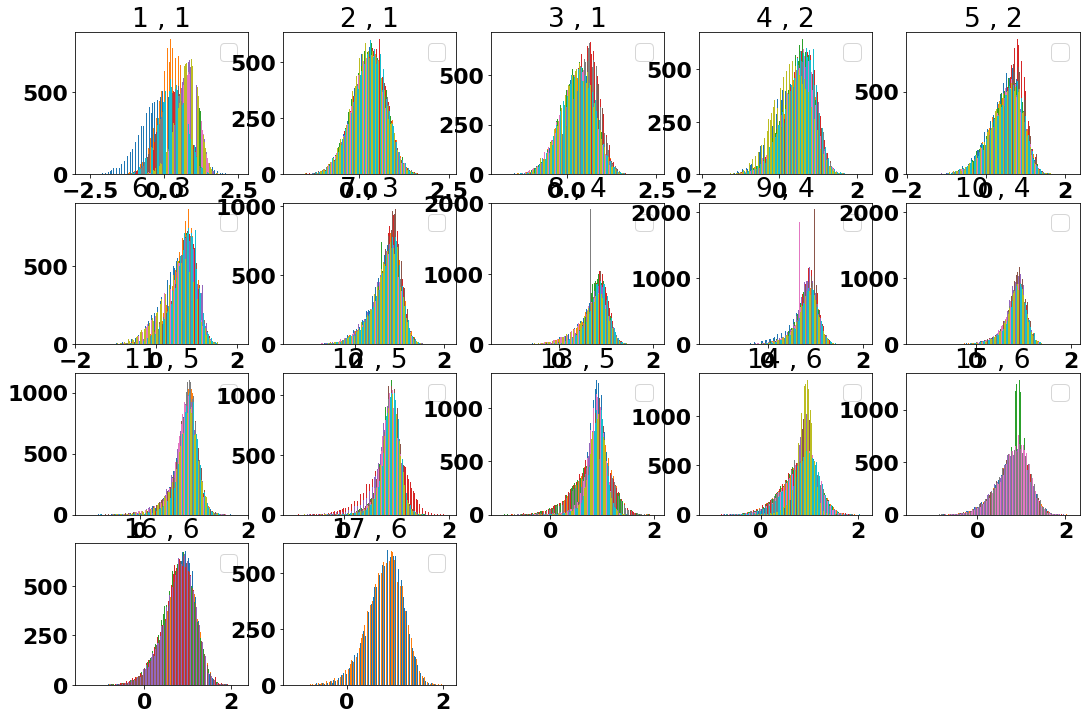

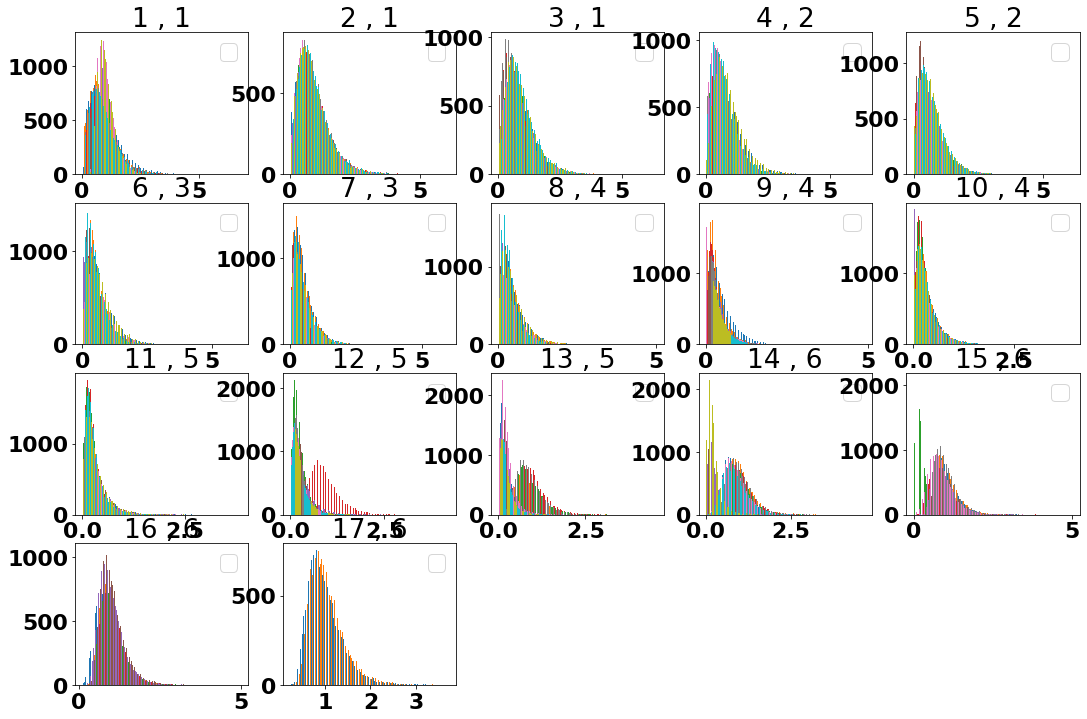

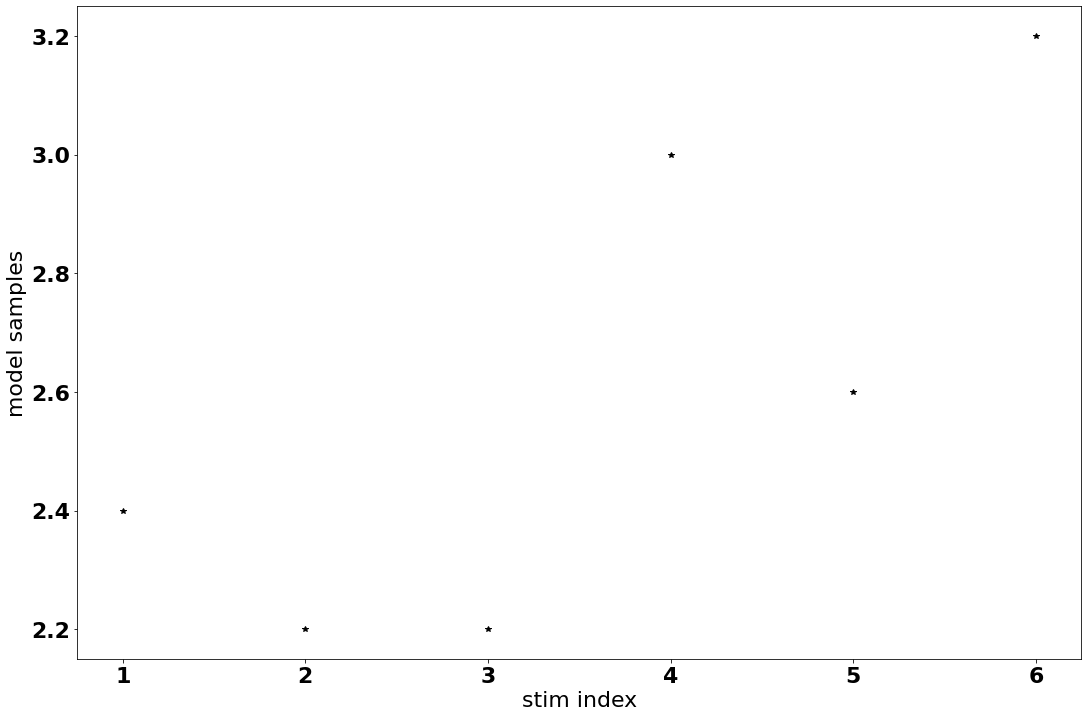

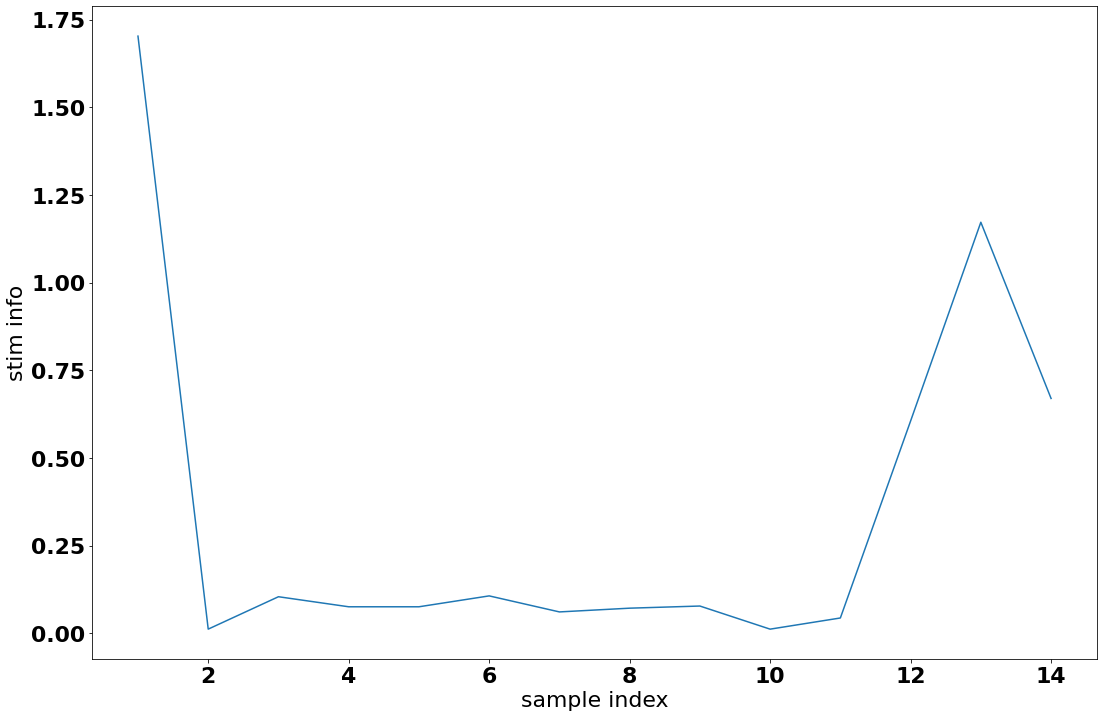

In [103]:
for run in np.arange(0, num_model_runs):
    
    print('model run: ', run)

    # generate the data
    sim_data = [np.random.multivariate_normal(exemplar_means[idx-1], sig) for idx in exemplar_idx] 
    sim_data = np.asmatrix(sim_data)

    # Iterators
    samples_from_current_stim = 1
    total_samples = 1
    exemplar_num = 1

    # initialize data
    sample_data = np.empty((num_samples,num_features))
    sample_data[:] = np.nan

    exemplar_labels = np.empty((num_samples,))
    exemplar_labels[:] = np.nan

    while sample or samples_from_current_stim > 1:
        
        print('stimulus: ', exemplar_num)
        
        print('sample: ', total_samples)

        
        # sample number
        data["M"] = total_samples

        # exemplar number 
        data["K"] = exemplar_num

        # add sim data
        sample_data[total_samples-1] = sim_data[exemplar_idx == exemplar_num][samples_from_current_stim-1]
        data["z"] = np.transpose(sample_data[0:total_samples,:])

        # add exemplar for each id
        exemplar_labels[total_samples-1] = int(exemplar_num)
        data["exemplar_idx"] = [int(x) for x in exemplar_labels[~np.isnan(exemplar_labels)]]

        # get posterior samples
        fit = sm.sampling(data=data, iter=num_iter, chains=1, warmup = num_warmup,control=dict(adapt_delta=0.95));
        
        
        posterior = np.hstack((fit['mu'][0:len(fit['mu']):thinning_factor], \
                               fit['sigma'][0:len(fit['mu']):thinning_factor]))
        
        # fit gmms
        gmm_p = GaussianMixture(n_components=2, random_state=0).fit(posterior)
        gmm_q = GaussianMixture(n_components=2, random_state=0).fit(prior)

        if total_samples < 30:
            
            plt.figure(1)
            plt.rcParams['figure.figsize'] = [18, 12]
            plt.subplot(4,5,total_samples)
            plt.hist(np.hstack((prior[:,[0]],posterior[:,[0]])), bins = 100);
            plt.title(str(total_samples) + " , " + str(exemplar_num))
            plt.legend('prior', 'posterior')
            
            plt.figure(2)
            plt.rcParams['figure.figsize'] = [18, 12]
            plt.subplot(4,5,total_samples)
            plt.hist(np.hstack((prior[:,[1]],posterior[:,[1]])), bins = 100);
            plt.title(str(total_samples) + " , " + str(exemplar_num))
            plt.legend('prior', 'posterior')
           
           
        else: 
            plt.show()
            break;
            
        if policy is 'kl':

            X = gmm_p.sample(posterior.shape[0])

            log_p_X = gmm_p.score_samples(X[0])
            log_q_X = gmm_q.score_samples(X[0])

            # KL divergence between prior and posterior
            stim_info[run, total_samples-1] = log_p_X.mean() - log_q_X.mean()

            
            #
            
            print('KL:',  stim_info[run,total_samples-1])

        elif policy is 'entropy':
            # reduction of entropy
            stim_info[run,total_samples-1] = np.abs(continuous.get_h(prior, k= 250) - continuous.get_h(posterior, k = 250))
            
            print('entropy change:',  stim_info[run,total_samples-1])
            
        elif policy is 'surprisal':   
                            
            # surprisal of current observation given prior
            stim_info[run, total_samples-1] = surprisal(np.squeeze(fit['z_rep'], axis = 1), sample_data[total_samples-1])
            
            print('surprisal:',  stim_info[run,total_samples-1])

        elif policy is 'EIG':
            
            hypothethical_grid = np.arange(-2, 2, 0.1)
            
            stim_info[run,total_samples-1] = EIG(posterior)

        # decision rule
        if stim_info[run,total_samples-1] < env_info:
            model_LT[run, exemplar_num-1] = samples_from_current_stim

            # reset/increment counters
            samples_from_current_stim = 1
            exemplar_num += 1

            if exemplar_num > sequence_length:
                sample = False

        else:
            samples_from_current_stim += 1 

        if policy is 'kl' or policy is 'surprisal' or policy is 'entropy':
            prior = posterior
        
        total_samples += 1

    # start sampling for next model run
    sample = True

    
plt.show()


font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

plt.plot(np.arange(1,sequence_length+1), np.mean(model_LT, axis = 0).squeeze(), 'k*')

plt.xlabel("stim index")
plt.ylabel("model samples")
plt.title("")

plt.show()


plt.plot(np.arange(1,total_samples+1),np.mean(stim_info, axis = 0)[0:total_samples].squeeze(), markersize = 20)

plt.xlabel("sample index")
plt.ylabel("stim info")
plt.title("")
plt.show()

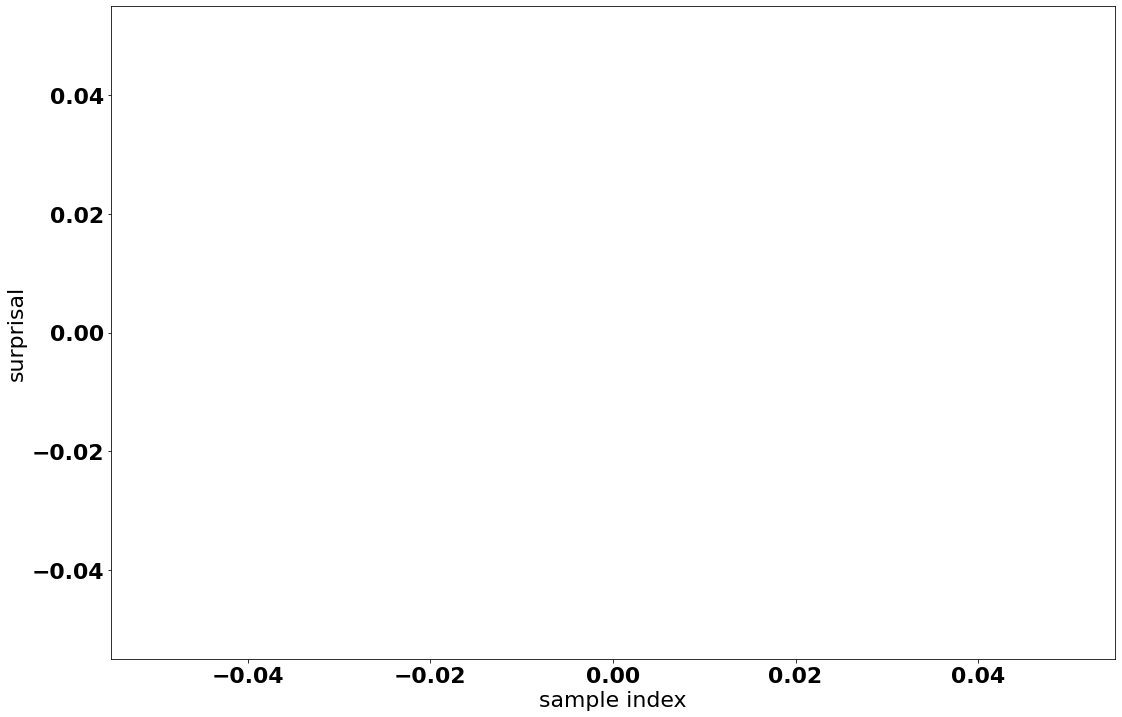

kl div: 1.9389252800833203
means
[0.0029953  1.02672432]
[0.77125344 0.41720897]
SD


NameError: name 'sd_prior' is not defined

In [71]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

#plt.plot(np.arange(1,sequence_length+1), np.mean(model_LT, axis = 0).squeeze(), 'k*', markersize = 20)

#plt.xlabel("stim index")
#plt.ylabel("model samples")
#plt.title("")

#plt.show()

plt.plot(np.arange(1,total_samples+1),np.mean(stim_info, axis = 0)[0:total_samples].squeeze(), markersize = 20)

plt.xlabel("sample index")
plt.ylabel("surprisal")
plt.title("")
plt.show()

mean_prior = np.mean(prior, axis = 0)

cov_prior = np.cov(np.transpose(prior))

mean_posterior = np.mean(posterior, axis = 0)

cov_posterior = np.cov(np.transpose(posterior))


print('kl div:', kl_mvn(mean_posterior, cov_posterior, mean_prior, cov_prior))


print("means")

print(mean_prior)
print(mean_posterior)

print("SD")
print(sd_prior)
print(sd_posterior)

print("data")
print(data['z'])
print(data['exemplar_idx'])


data['z']

posterior.shape




In [54]:
posterior.shape

(16000, 2)

In [72]:
gmm_p = GaussianMixture(n_components=2, random_state=0).fit(posterior)
gmm_q = GaussianMixture(n_components=2, random_state=0).fit(prior)

X = gmm_p.sample(posterior.shape[0])

log_p_X = gmm_p.score_samples(X[0])
log_q_X, _ = gmm_q.score_samples(X[0])

-3.7146721307353054

means:  [[0.27129736]
 [0.87890242]]
covariances:  [[[0.02682581]]

 [[0.22641521]]]
precisions:  [[[37.27753524]]

 [[ 4.41666434]]]
weights:  [0.70806028 0.29193972]


(0.0, 3500.0)

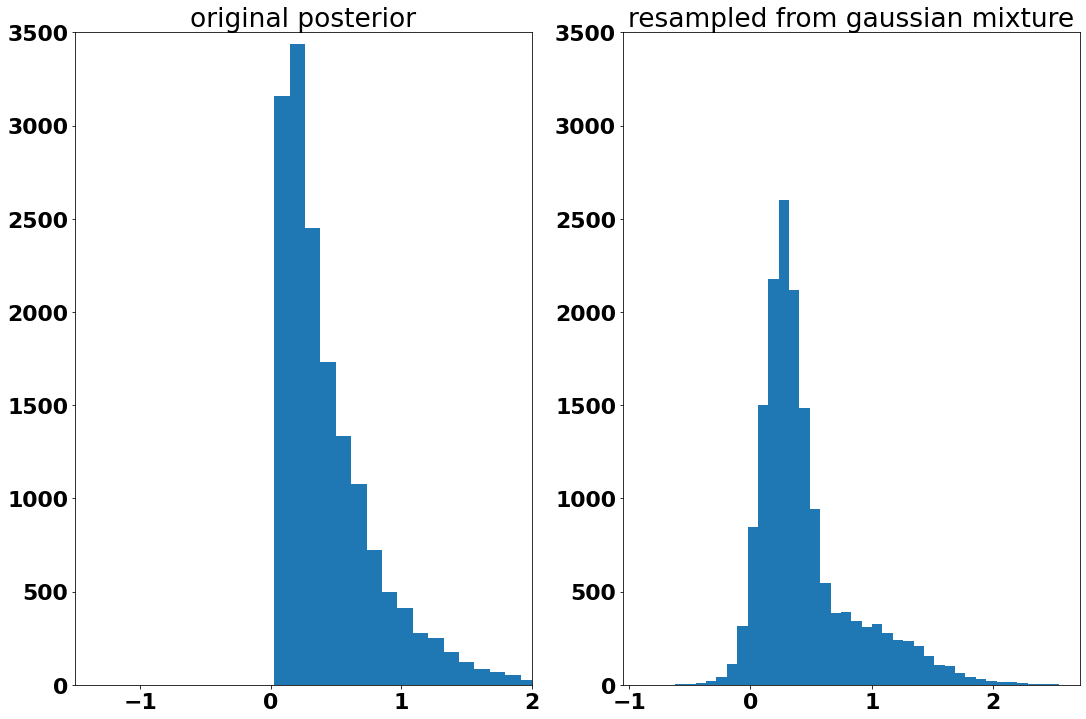

In [50]:
print('means: ', gm.means_)
print('covariances: ', gm.covariances_)

print('precisions: ', gm.precisions_)

print('weights: ', gm.weights_)


plt.subplot(1,2,1)
plt.hist(posterior[:,1], bins = 40)
plt.title('original posterior')
plt.xlim([-1.5, 2])
plt.ylim([0, 3500])

plt.subplot(1,2,2)
plt.hist(gm.sample(16000)[0], bins = 40)
plt.title('resampled from gaussian mixture')
plt.ylim([0, 3500])


In [42]:
posterior.shape

(16000, 2)

In [120]:
model_LT

array([[2., 2., 2., 3., 0., 0.],
       [2., 3., 4., 0., 0., 0.],
       [4., 3., 2., 0., 0., 0.]])

In [106]:
stim_info[1,0:20]

array([ 2.01619232,  0.00371586,  0.18321453,  0.19169076, -0.01187171,
        0.30167573,  0.0515528 ,  0.14896336, -0.01617405,  0.23803791,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan])

In [88]:
total_samples

21

In [107]:
exemplar_num
exemplar_labels

array([ 1.,  1.,  1., ..., nan, nan, nan])

In [113]:
stim_info.shape

(3, 3000)

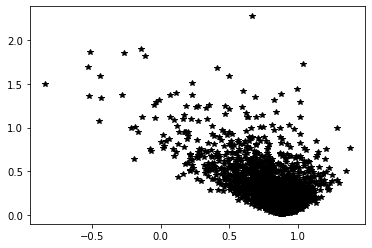

In [127]:
plt.plot(fit['mu'][0:len(fit['mu']):thinning_factor], fit['sigma'][0:len(fit['mu']):thinning_factor], 'k*')
plt.show()

(array([151., 418., 580., 683., 746., 822., 875., 918., 918., 878., 858.,
        851., 764., 730., 696., 676., 641., 600., 563., 504., 453., 389.,
        391., 322., 353., 293., 257., 244., 250., 211., 203., 171., 164.,
        133., 135., 118., 109.,  96.,  77.,  73.,  79.,  66.,  64.,  45.,
         44.,  36.,  35.,  37.,  32.,  34.,  24.,  17.,  28.,  11.,  19.,
          9.,  12.,  10.,   9.,   8.,   1.,   7.,   4.,   7.,   4.,   4.,
          4.,   3.,   2.,   3.,   1.,   3.,   4.,   2.,   2.,   1.,   1.,
          0.,   0.,   1.,   3.,   0.,   0.,   0.,   0.,   3.,   0.,   0.,
          0.,   1.,   0.,   0.,   1.,   1.,   1.,   0.,   1.,   1.,   0.,
          1.]),
 array([1.60952816e-02, 2.73371299e-01, 5.30647317e-01, 7.87923335e-01,
        1.04519935e+00, 1.30247537e+00, 1.55975139e+00, 1.81702741e+00,
        2.07430342e+00, 2.33157944e+00, 2.58885546e+00, 2.84613148e+00,
        3.10340750e+00, 3.36068351e+00, 3.61795953e+00, 3.87523555e+00,
        4.13251157e+00, 4.3897

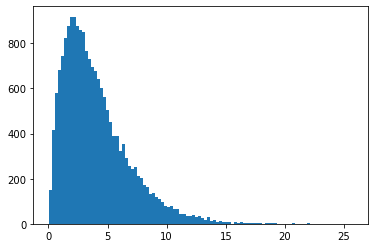

In [129]:
plt.hist(prior_sigma, bins = 100)